# MSSEG-2 Follow up images

This file contains the code for the MSSEG challenge attempt follow up MRI images.

## Setup environment

In [ ]:
!pip install -q "monai-weekly[all]"
!pip install -q matplotlib
%matplotlib inline

     |████████████████████████████████| 70.2 MB 54 kB/s 
     |████████████████████████████████| 53.9 MB 3.3 kB/s 


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    ResizeWithPadOrCropd,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
    ScaleIntensityRangePercentilesd,
    RandSpatialCropd,
    RandAxisFlipd,
    RandAdjustContrastd,
    SpatialPadd,
    RandBiasFieldd,
    RandGaussianSharpend,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ScaleIntensityd,
    AddChanneld,
    RepeatChanneld
)
from monai.networks.nets import UNet, UNETR, SegResNet, VNet, DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss, GeneralizedDiceLoss, FocalLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob


## Setup data directory
These paths are specific to my Google Drive, need to be updated.
Requires preprocessed images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/ML/MSSeg-2/colab'
print(root_dir)

/content/drive/MyDrive/ML/MSSeg-2/colab


In [ ]:
data_dir = '/content/drive/MyDrive/ML/MSSeg-2/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/preprocessed'

## Get filepaths for required images and split into training and validation lists

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "**/flair_time02_on_middle_space.nii.gz")))
first_images = sorted(
    glob.glob(os.path.join(data_dir, "**/flair_time01_on_middle_space.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "**/ground_truth.nii.gz")))

data_dicts = [
    {"image": image_name, "first_image": first_name, "label": label_name}
    for image_name, label_name, first_name in zip(train_images, train_labels, first_images)
]
train_files, val_files = data_dicts[:-8], data_dicts[-8:]


In [ ]:
len(train_files)
# train_files

32

In [ ]:
len(val_files)

8

## Setup transforms for training and validation

In [ ]:
keys = ["image", "label", "first_image"]

train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest", "bilinear")),
        Orientationd(keys=keys, axcodes="RAS"),
     
        NormalizeIntensityd(keys=["image", "first_image"]),
        ScaleIntensityRangePercentilesd(["image", "first_image"], 10, 99, 0.0, 1.0, True, False),

        CropForegroundd(keys=keys, source_key="image"),
        SpatialPadd(keys=keys, spatial_size=(96, 96, 96)),

        RandSpatialCropd(keys=keys, roi_size=(96, 96, 96), random_size=False),
        RandFlipd(keys=keys, prob=0.2, spatial_axis=0),
        RandFlipd(keys=keys, prob=0.2, spatial_axis=1),
        RandFlipd(keys=keys, prob=0.2, spatial_axis=2),
        RandRotate90d(
                keys=keys,
                prob=0.20,
                max_k=3,
        ),
     
        EnsureTyped(keys=keys),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest", "bilinear")),
        Orientationd(keys=keys, axcodes="RAS"),
     
        NormalizeIntensityd(keys=["image", "first_image"]),
        ScaleIntensityRangePercentilesd(["image", "first_image"], 10, 99, 0.0, 1.0, True, False),
     
        CropForegroundd(keys=keys, source_key="image"),
        EnsureTyped(keys=keys),
    ]
)

## Check transforms in DataLoader

In [ ]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
check_ds = Dataset(data=train_files, transform=train_transforms)
first_item = first(DataLoader(check_ds, batch_size=2))


torch.Size([2, 1, 96, 96, 96])
tensor(0.)


(tensor([41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44,
         44, 44]),
 tensor([27, 28, 29, 27, 27, 28, 28, 28, 28, 29, 29, 28, 28, 28, 29, 29, 29, 28,
         29, 29]),
 tensor([26, 26, 26, 26, 27, 24, 25, 26, 27, 26, 27, 24, 25, 26, 24, 25, 26, 25,
         24, 25]))

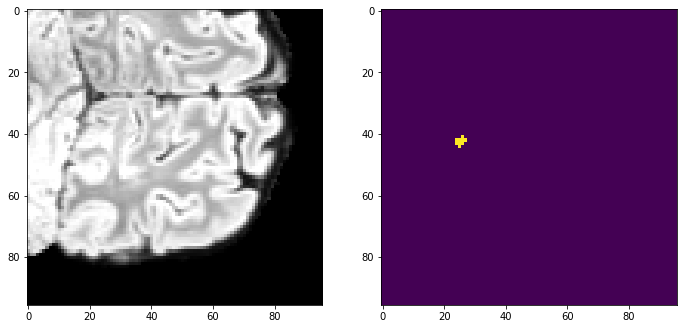

In [ ]:
# check_loader = check_loader_list[2]
print(first_item['image'].shape)

image = first_item['image'][0][0]
im_label = first_item['label'][0][0]


layer = 28
plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[:, layer,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(im_label[:, layer, :])


((im_label == 1).nonzero(as_tuple=True))


## Define Dataset and DataLoader for training and validation

We use CacheDataset to accelerate training and validation process, it's much faster than the regular Dataset.  
We cache all the data into memory as we have enough RAM. The results of every transformation before the first random transformation in the pipeline is applied and cached.


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=1)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)

Loading dataset: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]


In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

## Create Model, Loss, Optimizer

In [ ]:
device = torch.device("cuda:0")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)


weights = torch.tensor([1., 100.]).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, include_background = True, ce_weight=weights)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True, include_background = False)
# loss_function = FocalLoss(to_onehot_y=True, include_background = False)
# loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True, include_background = True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

## Training process

In [ ]:
max_epochs = 5000
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:

                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                roi_size = (96, 96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)

            # reset the status for next validation round
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/5000
1/4, train_loss: 1.4639
2/4, train_loss: 1.4530
3/4, train_loss: 1.4461
4/4, train_loss: 1.4310
epoch 1 average loss: 1.4485
----------
epoch 2/5000
1/4, train_loss: 1.4249
2/4, train_loss: 1.4166
3/4, train_loss: 1.4048
4/4, train_loss: 1.3919
epoch 2 average loss: 1.4096
----------
epoch 3/5000
1/4, train_loss: 1.3928
2/4, train_loss: 1.3829
3/4, train_loss: 1.3771
4/4, train_loss: 1.3700
epoch 3 average loss: 1.3807
----------
epoch 4/5000
1/4, train_loss: 1.3603
2/4, train_loss: 1.3580
3/4, train_loss: 1.3540
4/4, train_loss: 1.3432
epoch 4 average loss: 1.3539
----------
epoch 5/5000
1/4, train_loss: 1.3425
2/4, train_loss: 1.3411
3/4, train_loss: 1.3298
4/4, train_loss: 1.3288
epoch 5 average loss: 1.3355
saved new best metric model
current epoch: 5 current mean dice: 0.6016
best mean dice: 0.6016 at epoch: 5
----------
epoch 6/5000
1/4, train_loss: 1.3260
2/4, train_loss: 1.3174
3/4, train_loss: 1.3160
4/4, train_loss: 1.3140
epoch 6 average loss: 1.3183


KeyboardInterrupt: ignored

In [ ]:

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6355 at epoch: 20


In [ ]:
torch.save(metric_values, os.path.join(
                    root_dir, "metric_values.pth"))

## Plot the loss and metric

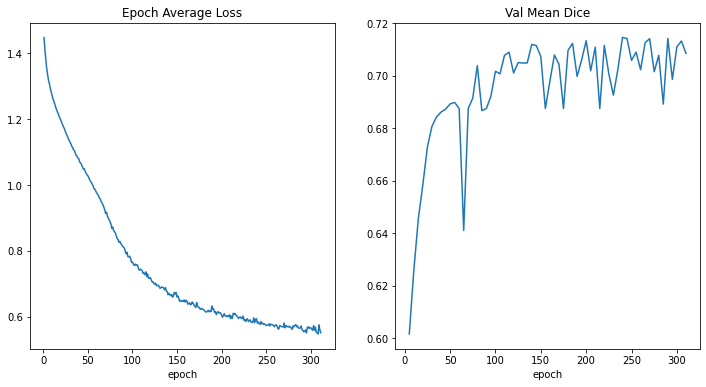

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

label: tensor(0.)
output: tensor(0)


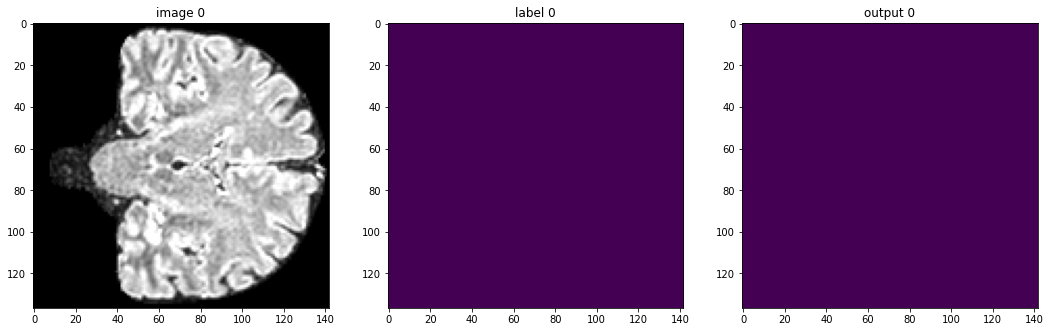

label: tensor(0.)
output: tensor(0)


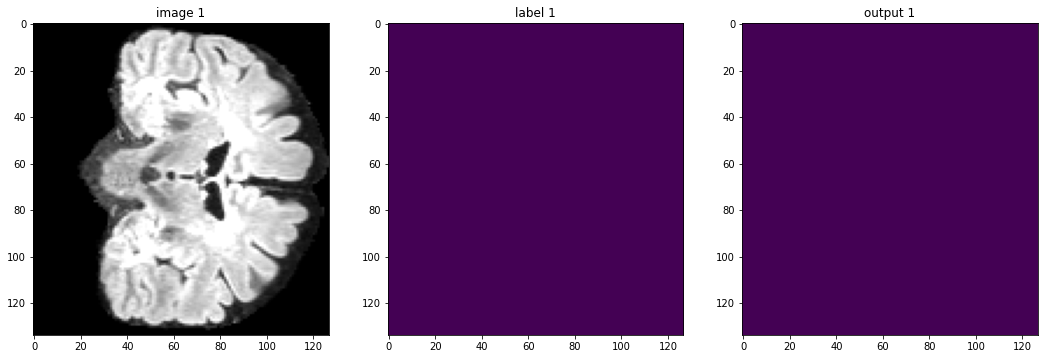

label: tensor(1.)
output: tensor(0)


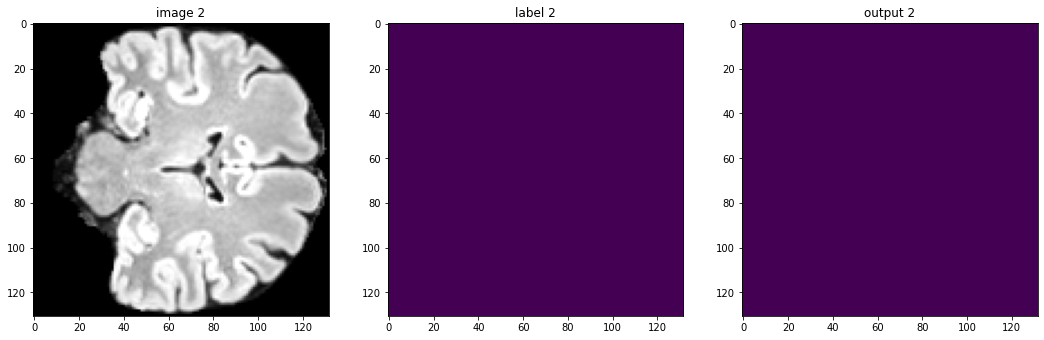

label: tensor(1.)
output: tensor(0)


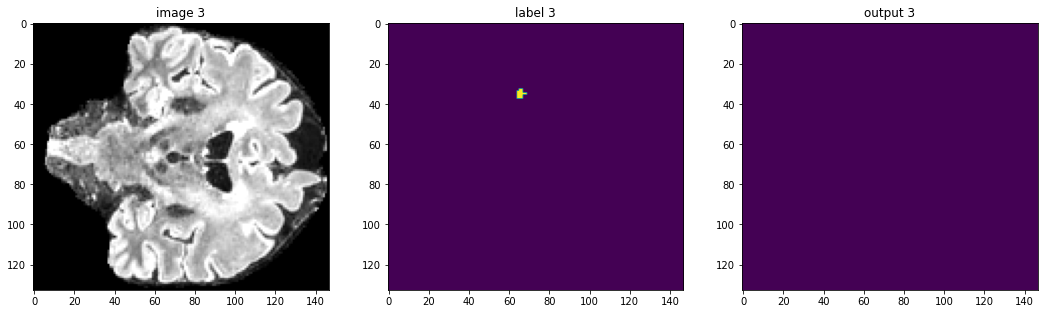

label: tensor(1.)
output: tensor(0)


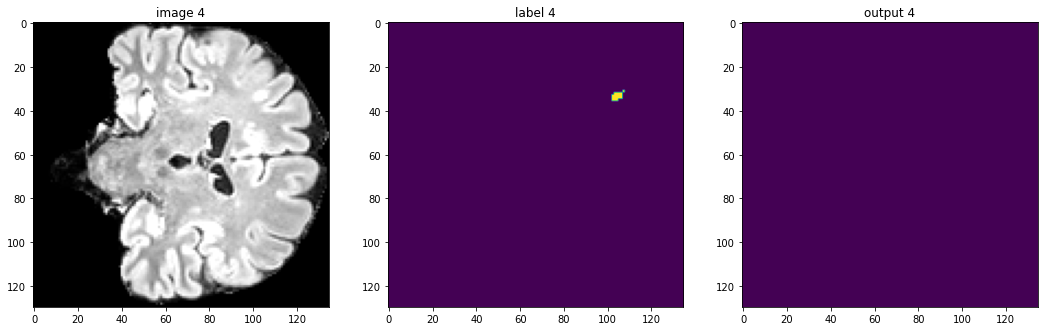

label: tensor(0.)
output: tensor(0)


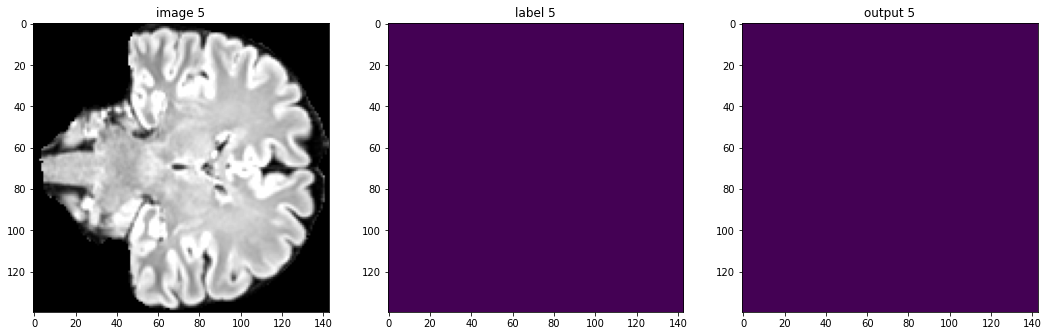

label: tensor(1.)
output: tensor(0)


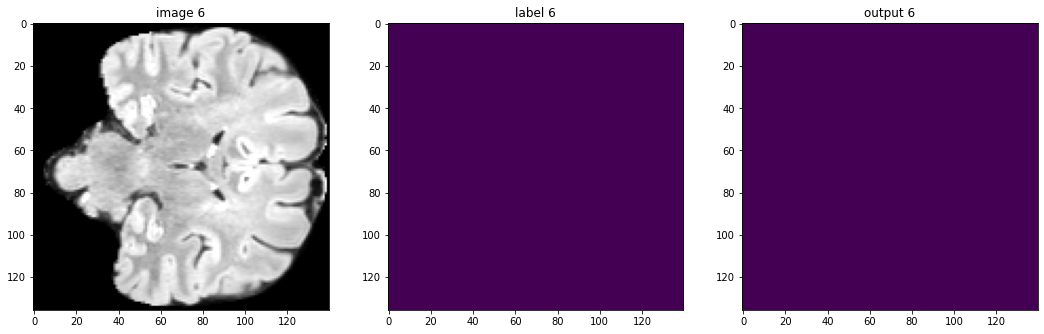

label: tensor(1.)
output: tensor(0)


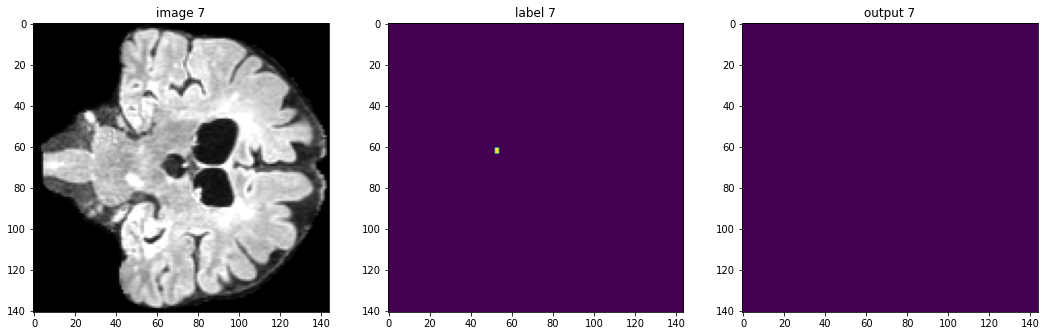

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
layer = 81
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        inputs = (val_data["image"] - val_data["first_image"]).to(device)
        val_outputs = sliding_window_inference(
            inputs, roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, layer, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        print("label:", torch.max(val_data["label"][0, 0, :, :, :]))
        plt.imshow(val_data["label"][0, 0, :, layer, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
        print("output:", torch.max(output))
        # print(((val_data["label"][0,0,:,:,:] == 1).nonzero(as_tuple=True)))
        plt.imshow(output[:, layer, :])
        plt.show()
        if i == 10:
            break